In [ ]:
Business Understanding for the Notebook
1. Problem Statement
Brain tumors are one of the most critical medical conditions that require early detection and accurate diagnosis. Traditional manual examination of medical images (MRI scans) is time-consuming, prone to errors, and requires expert radiologists. This project aims to develop a deep learning model to automatically detect and classify brain tumors, improving early diagnosis and patient outcomes.

2. Business Objectives
The key goals of this project are:
✅ Improve early detection – Automate tumor identification to support radiologists.
✅ Increase accuracy – Reduce human errors in diagnosing brain tumors.
✅ Reduce processing time – Accelerate the diagnosis process with AI.
✅ Assist medical professionals – Provide a tool that helps in medical decision-making.

3. Stakeholders & Users
👩‍⚕️ Doctors & Radiologists – To use the model for quick tumor detection.
🏥 Hospitals & Clinics – To integrate AI-based tumor detection in radiology departments.
📊 Medical Researchers – To improve deep learning techniques in medical imaging.

4. Impact & Value Proposition
💡 Improved Patient Outcomes – Faster and more accurate diagnoses lead to timely treatments.
💰 Cost Reduction – Reduces the workload of radiologists and minimizes unnecessary tests.
⚡ Scalability – AI models can process large volumes of MRI scans efficiently.

In [1]:
!pip install torch torchvision opencv-python matplotlib imutils
!pip install timm torch torchvision opencv-python matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [44]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
from PIL import Image
import imutils
import timm  # EfficientNet is available through the timm library
from torchvision.datasets import ImageFolder
from google.colab import drive
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
import torchvision.models as models
import random
from torchvision import transforms
from sklearn.metrics import classification_report
from torchvision import datasets, transforms

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
dataset_path = "/content/drive/MyDrive/dataset"

Cropping images

In [27]:
def crop_brain_tumor(image):
    """
    Automatically detects the largest contour in the image and crops the tumor region.
    """
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply binary threshold
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    if len(cnts) == 0:
        return image  # Return original if no tumor found

    # Get largest contour
    c = max(cnts, key=cv2.contourArea)

    # Find extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # Apply cropping
    ADD_PIXELS = 10  # Add padding
    cropped_image = image[max(0, extTop[1]-ADD_PIXELS):extBot[1]+ADD_PIXELS,
                          max(0, extLeft[0]-ADD_PIXELS):extRight[0]+ADD_PIXELS]

    return cropped_image

Data augmentation

In [28]:
class CustomTransform:
    def __call__(self, img):
        # Convert PIL image to NumPy array for OpenCV processing
        img_np = np.array(img)

        # Apply brain tumor cropping
        cropped_img = crop_brain_tumor(img_np)

        # Convert back to PIL Image for torchvision transformations
        img_pil = Image.fromarray(cropped_img)

        # Apply augmentations
        transform = transforms.Compose([
            transforms.Resize((224, 224)),  # Resize to standard size
            transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Crop randomly
            transforms.RandomRotation(30),  # Random rotation
            transforms.RandomHorizontalFlip(),  # Randomly flip image
            transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Color augmentation
            transforms.ToTensor(),  # Convert to tensor
            transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize
        ])

        return transform(img_pil)

Importing dataset

In [29]:
dataset = datasets.ImageFolder(root=dataset_path, transform=CustomTransform())
# Print class names
class_names = dataset.classes
print("Classes:", class_names)

Classes: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [30]:
# Define training transformation (with CustomTransform)
train_transform = transforms.Compose([
    CustomTransform()  # Apply your custom transform here!
])

# Define validation & test transformations (NO augmentations)
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize without distortion
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Keep same normalization
])

# Split dataset into train, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - (train_size + val_size)

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

# Apply different transforms manually
train_ds.dataset.transform = train_transform  # Apply CustomTransform to training set
val_ds.dataset.transform = val_test_transform  # Apply simple transforms to validation
test_ds.dataset.transform = val_test_transform  # Apply simple transforms to test set

# Create DataLoaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)  # Shuffle for training
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)  # No shuffle for validation
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)  # No shuffle for testing


Visulization

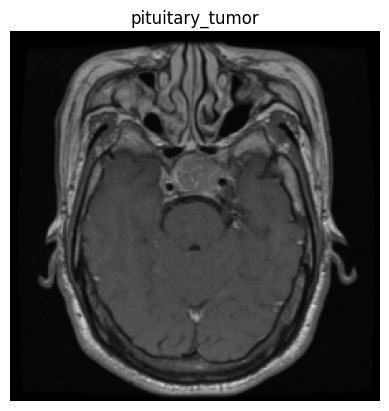

In [31]:
def imshow(img, label):
    # Unnormalize: reverse the normalization step (mean=0.5, std=0.5)
    img = img * 0.5 + 0.5
    npimg = img.numpy().transpose((1, 2, 0))  # Convert from Tensor to NumPy

    plt.imshow(npimg)
    plt.title(class_names[label])  # Display the class name
    plt.axis("off")
    plt.show()

# Get one batch of images from train_loader
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Display the first image in the batch
imshow(images[0], labels[0].item())


In [32]:
# Define the CNN model in PyTorch
class CNNModel(nn.Module):
    def __init__(self, conv_layers, layer_size, dense_layers):
        super(CNNModel, self).__init__()
        self.conv_layers = conv_layers
        self.layer_size = layer_size
        self.dense_layers = dense_layers

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, layer_size, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2)

        # Additional convolutional layers
        self.conv2 = nn.Conv2d(layer_size, layer_size, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(layer_size, layer_size, kernel_size=3, padding=1)

        # Calculate the size of the feature map after the convolutional layers
        # Assuming input size of 224x224, and 2x2 pooling after each conv layer
        self.feature_map_size = 224 // (2 ** conv_layers)  # Dividing by 2 for each pooling layer

        # Flatten layer
        self.flatten = nn.Flatten()

        # Fully connected layers
        self.fc1 = nn.Linear(layer_size * self.feature_map_size * self.feature_map_size, dense_layers * 128)  # Adjust size
        self.fc2 = nn.Linear(dense_layers * 128, 4)  # 4 output classes

        # Dropout layer
        self.dropout = nn.Dropout(0.33)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)

        if self.conv_layers > 1:
            x = self.relu(self.conv2(x))
            x = self.maxpool(x)

        if self.conv_layers > 2:
            x = self.relu(self.conv3(x))
            x = self.maxpool(x)

        x = self.flatten(x)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

In [33]:
# Function to train the model
def train_model(model, train_loader, val_loader, device, epochs=20):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels.data)
            total_preds += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct_preds.double() / total_preds
        print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f} - Accuracy: {epoch_acc:.4f}")

        # Save checkpoint after each epoch
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': running_loss / len(train_loader)
        }
        checkpoint_path = "/content/drive/My Drive/cnn_brain_tumor_checkpoint.pth"
        save_checkpoint(checkpoint, checkpoint_path)

        # Evaluate the model on validation data
        val_acc = evaluate_model(model, val_loader, device)
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict()

    model.load_state_dict(best_model_wts)
    return model


In [38]:
# Save checkpoint function
def save_checkpoint(checkpoint, checkpoint_path):
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved to {checkpoint_path}")

In [39]:
# Load checkpoint function
def load_checkpoint(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(f"Checkpoint loaded from {checkpoint_path}")
    print(f"Resumed from epoch {epoch}, loss: {loss}")
    return model, optimizer, epoch

In [40]:
# Function to evaluate the model
def evaluate_model(model, val_loader, device):
    model.eval()
    correct_preds = 0
    total_preds = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels.data)
            total_preds += labels.size(0)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    accuracy = correct_preds.double() / total_preds
    print(f"Validation Accuracy: {accuracy:.4f}")

    # Print classification report
    print(classification_report(y_true, y_pred))
    return accuracy

In [41]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
conv_layers = 3
layer_size = 64
dense_layers = 2
epochs = 20

# Initialize model
model = CNNModel(conv_layers=conv_layers, layer_size=layer_size, dense_layers=dense_layers)

Using device: cuda


In [42]:
# Train the model
trained_model = train_model(model, train_loader, val_loader, device, epochs)

# Evaluate the model
evaluate_model(trained_model, val_loader, device)


Epoch 1/20 - Loss: 1.0658 - Accuracy: 0.5746
Checkpoint saved to /content/drive/My Drive/cnn_brain_tumor_checkpoint.pth
Validation Accuracy: 0.6741
              precision    recall  f1-score   support

           0       0.68      0.69      0.69       211
           1       0.70      0.44      0.54       199
           2       0.59      0.66      0.62        62
           3       0.68      0.94      0.79       160

    accuracy                           0.67       632
   macro avg       0.66      0.68      0.66       632
weighted avg       0.68      0.67      0.66       632

Epoch 2/20 - Loss: 0.6426 - Accuracy: 0.7382
Checkpoint saved to /content/drive/My Drive/cnn_brain_tumor_checkpoint.pth
Validation Accuracy: 0.7706
              precision    recall  f1-score   support

           0       0.75      0.78      0.76       211
           1       0.76      0.61      0.68       199
           2       0.60      0.90      0.72        62
           3       0.91      0.91      0.91       16

tensor(0.8861, device='cuda:0', dtype=torch.float64)

In [43]:
# Function to test the model
def test_model(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    correct_preds = 0
    total_preds = 0
    y_true = []
    y_pred = []

    with torch.no_grad():  # No need to calculate gradients during testing
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels.data)
            total_preds += labels.size(0)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    accuracy = correct_preds.double() / total_preds
    print(f"Test Accuracy: {accuracy:.4f}")

    # Print classification report
    print(classification_report(y_true, y_pred))
    return accuracy

# Assuming you already have the test_loader prepared

# Test the model
test_accuracy = test_model(trained_model, test_loader, device)

Test Accuracy: 0.8608
              precision    recall  f1-score   support

           0       0.81      0.90      0.86        92
           1       0.88      0.78      0.83        96
           2       0.78      0.74      0.76        42
           3       0.93      0.97      0.95        86

    accuracy                           0.86       316
   macro avg       0.85      0.85      0.85       316
weighted avg       0.86      0.86      0.86       316



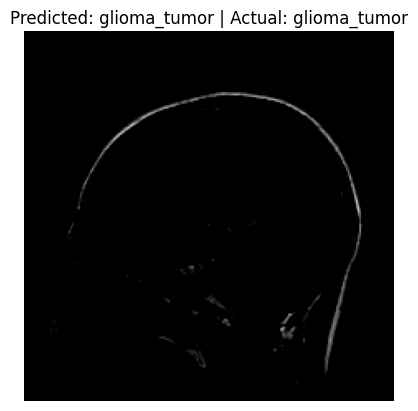

Predicted Label: glioma_tumor
Actual Label: glioma_tumor


In [49]:
def test_random_image(model, test_loader, device, class_names):
    # Set the model to evaluation mode
    model.eval()

    # Get a random sample from the test_loader
    dataiter = iter(test_loader)
    images, labels = next(dataiter)

    # Select a random image and its corresponding label
    idx = random.randint(0, len(images) - 1)
    img = images[idx].unsqueeze(0).to(device)  # Add batch dimension and move to device
    true_label = labels[idx].item()

    # Make prediction
    with torch.no_grad():  # Disable gradient calculation
        output = model(img)
        _, predicted = torch.max(output, 1)

    predicted_label = predicted.item()

    # Convert the image back to a format for display
    img = img.squeeze().cpu().numpy().transpose(1, 2, 0)  # Convert to HWC format

    # Display the image along with predicted and actual labels
    plt.imshow(img)
    plt.title(f"Predicted: {class_names[predicted_label]} | Actual: {class_names[true_label]}")
    plt.axis('off')
    plt.show()

    # Print the actual and predicted labels
    print(f"Predicted Label: {class_names[predicted_label]}")
    print(f"Actual Label: {class_names[true_label]}")

# Call the function to test on a random image
test_random_image(trained_model, test_loader, device, class_names)

## **1.SWIN :**

In [50]:
# Charger Swin-Tiny pré-entraîné
model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=len(dataset.classes))

# Définir l'appareil (GPU si disponible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Freeze the early layers and fine-tune the last few layers (classifier head)
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers

# Unfreeze the classifier layer (head)
for param in model.head.parameters():
    param.requires_grad = True

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 20

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Époque {epoch+1}/{num_epochs} - Perte: {running_loss/len(train_loader):.4f}")

print("Entraînement terminé !")

# Evaluation on the validation set
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Accurancy: {accuracy * 100:.2f}%")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

Époque 1/20 - Perte: 1.3361
Époque 2/20 - Perte: 1.1792
Époque 3/20 - Perte: 1.0834
Époque 4/20 - Perte: 1.0014
Époque 5/20 - Perte: 0.9427
Époque 6/20 - Perte: 0.8847
Époque 7/20 - Perte: 0.8458
Époque 8/20 - Perte: 0.8030
Époque 9/20 - Perte: 0.7770
Époque 10/20 - Perte: 0.7423
Époque 11/20 - Perte: 0.7225
Époque 12/20 - Perte: 0.7084
Époque 13/20 - Perte: 0.6900
Époque 14/20 - Perte: 0.6743
Époque 15/20 - Perte: 0.6561
Époque 16/20 - Perte: 0.6431
Époque 17/20 - Perte: 0.6234
Époque 18/20 - Perte: 0.6115
Époque 19/20 - Perte: 0.6028
Époque 20/20 - Perte: 0.5955
Entraînement terminé !
Accurancy: 79.59%


# a.Test Model :

In [51]:
# Function to test the model
def test_model(model, test_loader, device, class_names):
    model.eval()  # Set the model to evaluation mode
    correct_preds = 0
    total_preds = 0
    y_true = []
    y_pred = []

    with torch.no_grad():  # No need to calculate gradients during testing
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels.data)
            total_preds += labels.size(0)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    accuracy = correct_preds.double() / total_preds
    print(f"Test Accuracy: {accuracy:.4f}")

    # Print classification report
    print(classification_report(y_true, y_pred, target_names=class_names))
    return accuracy



# Test the model (using your trained model)
test_accuracy = test_model(model, test_loader, device, class_names)


Test Accuracy: 0.8165
                  precision    recall  f1-score   support

    glioma_tumor       0.83      0.80      0.82        92
meningioma_tumor       0.75      0.75      0.75        96
        no_tumor       0.94      0.79      0.86        42
 pituitary_tumor       0.82      0.92      0.87        86

        accuracy                           0.82       316
       macro avg       0.84      0.81      0.82       316
    weighted avg       0.82      0.82      0.82       316



# b.Test Random Image

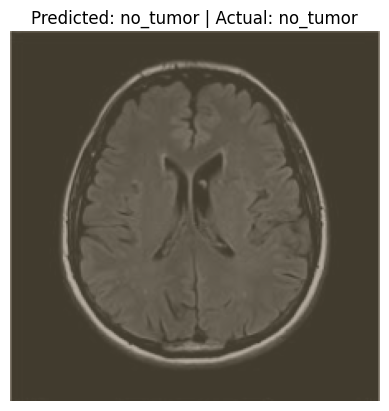

Predicted Label: no_tumor
Actual Label: no_tumor


In [52]:
def test_random_image(model, test_loader, device, class_names):
    # Set the model to evaluation mode
    model.eval()

    # Get a random sample from the test_loader
    dataiter = iter(test_loader)
    images, labels = next(dataiter)

    # Select a random image and its corresponding label
    idx = random.randint(0, len(images) - 1)
    img = images[idx].unsqueeze(0).to(device)  # Add batch dimension and move to device
    true_label = labels[idx].item()

    # Make prediction
    with torch.no_grad():  # Disable gradient calculation
        output = model(img)
        _, predicted = torch.max(output, 1)

    predicted_label = predicted.item()

    # Convert the image back to a format for display
    img = img.squeeze().cpu().numpy().transpose(1, 2, 0)  # Convert to HWC format

    # Normalize the image to match the Swin-Tiny's input normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  # Denormalize
    img = np.clip(img, 0, 1)  # Ensure the image is in the correct range

    # Display the image along with predicted and actual labels
    plt.imshow(img)
    plt.title(f"Predicted: {class_names[predicted_label]} | Actual: {class_names[true_label]}")
    plt.axis('off')
    plt.show()

    # Print the actual and predicted labels
    print(f"Predicted Label: {class_names[predicted_label]}")
    print(f"Actual Label: {class_names[true_label]}")

# Call the function to test on a random image
test_random_image(model, test_loader, device, class_names)


# **2.ResNeT**

In [53]:
# Load pre-trained ResNet18 model
model = models.resnet18(pretrained=True)

# Modify the final fully connected layer for your number of classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(dataset.classes))

# Set device to CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Freeze all layers except the final one (fc layer)
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers

# Unfreeze the final classifier layer
for param in model.fc.parameters():
    param.requires_grad = True  # Unfreeze the classifier layer

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()

# Optimizer should only optimize the parameters of the final layer
optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()  # Zero the gradients

        # Forward pass to get predictions
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass to calculate gradients
        loss.backward()

        # Step the optimizer to update the weights
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {running_loss/len(train_loader):.4f}")

print("Training complete!")

# Evaluation
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy * 100:.2f}%")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 58.2MB/s]


Epoch 1/20 - Loss: 1.4049
Epoch 2/20 - Loss: 1.2336
Epoch 3/20 - Loss: 1.1298
Epoch 4/20 - Loss: 1.0412
Epoch 5/20 - Loss: 0.9691
Epoch 6/20 - Loss: 0.9168
Epoch 7/20 - Loss: 0.8718
Epoch 8/20 - Loss: 0.8232
Epoch 9/20 - Loss: 0.7928
Epoch 10/20 - Loss: 0.7699
Epoch 11/20 - Loss: 0.7323
Epoch 12/20 - Loss: 0.7173
Epoch 13/20 - Loss: 0.7059
Epoch 14/20 - Loss: 0.6738
Epoch 15/20 - Loss: 0.6737
Epoch 16/20 - Loss: 0.6508
Epoch 17/20 - Loss: 0.6587
Epoch 18/20 - Loss: 0.6225
Epoch 19/20 - Loss: 0.6208
Epoch 20/20 - Loss: 0.6111
Training complete!
Accuracy: 78.16%


# a.Test Model :

In [59]:
# Function to test the model
def test_model(model, test_loader, device, class_names):
    model.eval()  # Set the model to evaluation mode
    correct_preds = 0
    total_preds = 0
    y_true = []
    y_pred = []

    with torch.no_grad():  # No need to calculate gradients during testing
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels.data)
            total_preds += labels.size(0)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    accuracy = correct_preds.double() / total_preds
    print(f"Test Accuracy: {accuracy:.4f}")

    # Print classification report
    print(classification_report(y_true, y_pred, target_names=class_names))
    return accuracy



# Test the ResNet18 model
test_accuracy = test_model(model, test_loader, device, class_names)


Test Accuracy: 0.7753
                  precision    recall  f1-score   support

    glioma_tumor       0.83      0.74      0.78        92
meningioma_tumor       0.72      0.68      0.70        96
        no_tumor       0.84      0.74      0.78        42
 pituitary_tumor       0.76      0.94      0.84        86

        accuracy                           0.78       316
       macro avg       0.79      0.77      0.78       316
    weighted avg       0.78      0.78      0.77       316



# b.Test Random Image

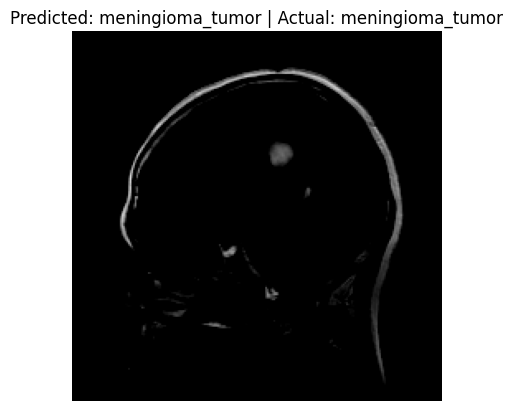

Predicted Label: meningioma_tumor
Actual Label: meningioma_tumor


In [57]:
# Function to test a random image
def test_random_image(model, test_loader, device, class_names):
    model.eval()  # Set the model to evaluation mode

    # Get a random sample from the test_loader
    dataiter = iter(test_loader)
    images, labels = next(dataiter)

    # Select a random image and its corresponding label
    idx = random.randint(0, len(images) - 1)
    img = images[idx].unsqueeze(0).to(device)  # Add batch dimension and move to device
    true_label = labels[idx].item()

    # Make prediction
    with torch.no_grad():  # Disable gradient calculation
        output = model(img)
        _, predicted = torch.max(output, 1)

    predicted_label = predicted.item()

    # Convert the image back to a format for display
    img = img.squeeze().cpu().numpy().transpose(1, 2, 0)  # Convert to HWC format

    # Display the image along with predicted and actual labels
    plt.imshow(img)
    plt.title(f"Predicted: {class_names[predicted_label]} | Actual: {class_names[true_label]}")
    plt.axis('off')
    plt.show()

    # Print the actual and predicted labels
    print(f"Predicted Label: {class_names[predicted_label]}")
    print(f"Actual Label: {class_names[true_label]}")

# Call the function to test on a random image
test_random_image(model, test_loader, device, class_names)


# **3.VGG16**

In [58]:

# Load pre-trained VGG16 model
model = models.vgg16(pretrained=True)

# Modify the final fully connected layer for your number of classes
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, len(dataset.classes))

# Set device to CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Freeze all layers except the final classifier
for param in model.parameters():
    param.requires_grad = False
# Unfreeze the final classifier layer
for param in model.classifier[6].parameters():
    param.requires_grad = True

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()

# Pass only the parameters of the final layer to the optimizer
optimizer = optim.Adam(model.classifier[6].parameters(), lr=0.0001)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {running_loss/len(train_loader):.4f}")

print("Training complete!")

# Evaluation
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy * 100:.2f}%")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 174MB/s]


Epoch 1/20 - Loss: 1.1944
Epoch 2/20 - Loss: 0.9592
Epoch 3/20 - Loss: 0.8546
Epoch 4/20 - Loss: 0.8061
Epoch 5/20 - Loss: 0.7452
Epoch 6/20 - Loss: 0.7312
Epoch 7/20 - Loss: 0.6832
Epoch 8/20 - Loss: 0.6839
Epoch 9/20 - Loss: 0.6584
Epoch 10/20 - Loss: 0.6490
Epoch 11/20 - Loss: 0.6318
Epoch 12/20 - Loss: 0.6139
Epoch 13/20 - Loss: 0.6221
Epoch 14/20 - Loss: 0.5992
Epoch 15/20 - Loss: 0.5936
Epoch 16/20 - Loss: 0.5805
Epoch 17/20 - Loss: 0.5751
Epoch 18/20 - Loss: 0.5782
Epoch 19/20 - Loss: 0.5606
Epoch 20/20 - Loss: 0.5652
Training complete!
Accuracy: 79.11%


# a.Test Model :

In [60]:
# Function to test the model
def test_model(model, test_loader, device, class_names):
    model.eval()  # Set the model to evaluation mode
    correct_preds = 0
    total_preds = 0
    y_true = []
    y_pred = []

    with torch.no_grad():  # No need to calculate gradients during testing
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels.data)
            total_preds += labels.size(0)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    accuracy = correct_preds.double() / total_preds
    print(f"Test Accuracy: {accuracy:.4f}")

    # Print classification report
    print(classification_report(y_true, y_pred, target_names=class_names))
    return accuracy



# Test the VGG16 model
test_accuracy = test_model(model, test_loader, device, class_names)


Test Accuracy: 0.7753
                  precision    recall  f1-score   support

    glioma_tumor       0.83      0.74      0.78        92
meningioma_tumor       0.72      0.68      0.70        96
        no_tumor       0.84      0.74      0.78        42
 pituitary_tumor       0.76      0.94      0.84        86

        accuracy                           0.78       316
       macro avg       0.79      0.77      0.78       316
    weighted avg       0.78      0.78      0.77       316



# b.Test Random Image

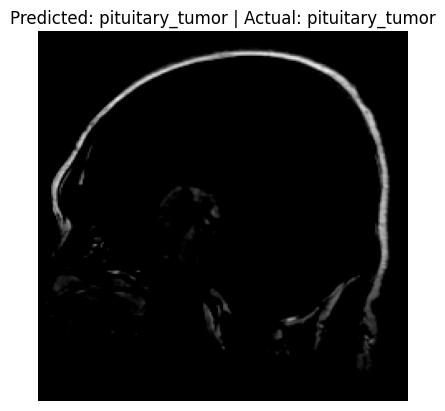

Predicted Label: pituitary_tumor
Actual Label: pituitary_tumor


In [62]:
import random
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
from torchvision import transforms

# Function to test a random image
def test_random_image(model, test_loader, device, class_names):
    model.eval()  # Set the model to evaluation mode

    # Get a random sample from the test_loader
    dataiter = iter(test_loader)
    images, labels = next(dataiter)

    # Select a random image and its corresponding label
    idx = random.randint(0, len(images) - 1)
    img = images[idx].unsqueeze(0).to(device)  # Add batch dimension and move to device
    true_label = labels[idx].item()

    # Make prediction
    with torch.no_grad():  # Disable gradient calculation
        output = model(img)
        _, predicted = torch.max(output, 1)

    predicted_label = predicted.item()

    # Convert the image back to a format for display
    img = img.squeeze().cpu().numpy().transpose(1, 2, 0)  # Convert to HWC format

    # Display the image along with predicted and actual labels
    plt.imshow(img)
    plt.title(f"Predicted: {class_names[predicted_label]} | Actual: {class_names[true_label]}")
    plt.axis('off')
    plt.show()

    # Print the actual and predicted labels
    print(f"Predicted Label: {class_names[predicted_label]}")
    print(f"Actual Label: {class_names[true_label]}")

# Call the function to test on a random image
test_random_image(model, test_loader, device, class_names)


# **4.EfficientNet**

In [63]:
# Load pre-trained EfficientNet-B0 model
model = timm.create_model('efficientnet_b0', pretrained=True)

# Modify the final layer to match the number of classes
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, len(dataset.classes))

# Set device to CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Freeze all layers except the final classifier
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the final classifier layer
for param in model.classifier.parameters():
    param.requires_grad = True

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()

# Optimizer should only optimize the parameters of the final classifier
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {running_loss/len(train_loader):.4f}")

print("Training complete!")

# Evaluation
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy * 100:.2f}%")


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Epoch 1/20 - Loss: 1.2448
Epoch 2/20 - Loss: 1.0600
Epoch 3/20 - Loss: 0.9415
Epoch 4/20 - Loss: 0.8642
Epoch 5/20 - Loss: 0.7993
Epoch 6/20 - Loss: 0.7386
Epoch 7/20 - Loss: 0.6982
Epoch 8/20 - Loss: 0.6721
Epoch 9/20 - Loss: 0.6447
Epoch 10/20 - Loss: 0.6271
Epoch 11/20 - Loss: 0.5973
Epoch 12/20 - Loss: 0.5960
Epoch 13/20 - Loss: 0.5627
Epoch 14/20 - Loss: 0.5672
Epoch 15/20 - Loss: 0.5445
Epoch 16/20 - Loss: 0.5357
Epoch 17/20 - Loss: 0.5243
Epoch 18/20 - Loss: 0.5100
Epoch 19/20 - Loss: 0.5088
Epoch 20/20 - Loss: 0.5152
Training complete!
Accuracy: 84.65%


# a.Test Model :

In [64]:
# Function to test the model
def test_model(model, test_loader, device, class_names):
    model.eval()  # Set the model to evaluation mode
    correct_preds = 0
    total_preds = 0
    y_true = []
    y_pred = []

    with torch.no_grad():  # No need to calculate gradients during testing
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels.data)
            total_preds += labels.size(0)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    accuracy = correct_preds.double() / total_preds
    print(f"Test Accuracy: {accuracy:.4f}")

    # Print classification report
    print(classification_report(y_true, y_pred, target_names=class_names))
    return accuracy



# Test the EfficientNet-B0 model
test_accuracy = test_model(model, test_loader, device, class_names)


Test Accuracy: 0.8291
                  precision    recall  f1-score   support

    glioma_tumor       0.85      0.77      0.81        92
meningioma_tumor       0.76      0.75      0.75        96
        no_tumor       0.80      0.86      0.83        42
 pituitary_tumor       0.90      0.97      0.93        86

        accuracy                           0.83       316
       macro avg       0.83      0.84      0.83       316
    weighted avg       0.83      0.83      0.83       316



# b.Test Random Image

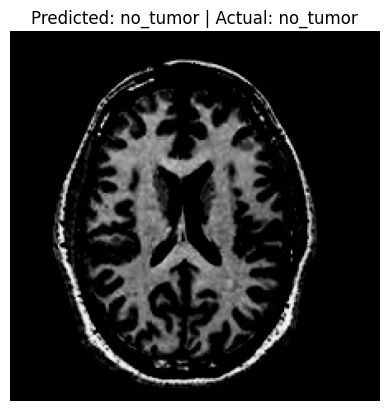

Predicted Label: no_tumor
Actual Label: no_tumor


In [66]:
# Function to test a random image
def test_random_image(model, test_loader, device, class_names):
    model.eval()  # Set the model to evaluation mode

    # Get a random sample from the test_loader
    dataiter = iter(test_loader)
    images, labels = next(dataiter)

    # Select a random image and its corresponding label
    idx = random.randint(0, len(images) - 1)
    img = images[idx].unsqueeze(0).to(device)  # Add batch dimension and move to device
    true_label = labels[idx].item()

    # Make prediction
    with torch.no_grad():  # Disable gradient calculation
        output = model(img)
        _, predicted = torch.max(output, 1)

    predicted_label = predicted.item()

    # Convert the image back to a format for display
    img = img.squeeze().cpu().numpy().transpose(1, 2, 0)  # Convert to HWC format

    # Display the image along with predicted and actual labels
    plt.imshow(img)
    plt.title(f"Predicted: {class_names[predicted_label]} | Actual: {class_names[true_label]}")
    plt.axis('off')
    plt.show()

    # Print the actual and predicted labels
    print(f"Predicted Label: {class_names[predicted_label]}")
    print(f"Actual Label: {class_names[true_label]}")

# Call the function to test on a random image
test_random_image(model, test_loader, device, class_names)
